In [1]:
#pip install fancyimpute scikit-learn

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, ShuffleSplit, KFold, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score, mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression

## Load data

In [5]:
for file_name in os.listdir("files"):
    if file_name.endswith('.csv'):
        file_path = os.path.join("files", file_name)

        df_name = os.path.splitext(file_name)[0]
        globals()[df_name] = pd.read_csv(file_path)

## DATA CLEANING

## Simplification of categories

In [8]:
# Merge sports data and extract sports categories
def extract_sports_category(dataset, sports_code):
    merged = pd.merge(dataset, sports_code, left_on="Sports", right_on="Code")
    merged["Sports_Category"] = merged["Categorie"]
    return merged[["PRIMARY_KEY", "Sports_Category"]]

learn_sports = extract_sports_category(learn_dataset_sport, code_Sports)
test_sports = extract_sports_category(test_dataset_sport, code_Sports)

# Merge departments into regions and extract relevant region columns
def merge_and_extract_region(df, merge_column, region_column_name):
    merged = pd.merge(df, departments, left_on=merge_column, right_on="DEP", how="left")
    merged[region_column_name] = merged["REG"]
    return merged.drop(["Nom du département", "REG", "DEP", merge_column], axis=1)

In [9]:
learn_dataset_job = merge_and_extract_region(learn_dataset_job, "JOB_DEP", "JOB_REG")    #put the column as int 
learn_dataset_retired_jobs = merge_and_extract_region(learn_dataset_retired_jobs, "JOB_DEP", "JOB_REG")
learn_dataset_retired_jobs = merge_and_extract_region(learn_dataset_retired_jobs, "FORMER_DEP", "FORMER_REG")

test_dataset_job = merge_and_extract_region(test_dataset_job, "JOB_DEP", "JOB_REG")
test_dataset_retired_jobs = merge_and_extract_region(test_dataset_retired_jobs, "JOB_DEP", "JOB_REG")
test_dataset_retired_jobs = merge_and_extract_region(test_dataset_retired_jobs, "FORMER_DEP", "FORMER_REG")

In [10]:
#Economic sector into fewer categories (and numeric instead of object/string)
def sector_mapping(nace_code):
    if nace_code == "AZ":  
        return "Agriculture, forestry and fishing)"
    elif "BZ" <= nace_code <= "EZ":
        return "Manufacturing, mining and quarrying and other industrial activities"
    elif nace_code == "FZ": 
        return "Construction"
    elif "GZ" <= nace_code <= "IZ":  
        return "Wholesale and retail trade, transportation and storage, accommodation and food service activities"
    elif "JA" <= nace_code <= "JC":
        return "Information and communication"
    elif nace_code == "KZ": 
        return "Financial and insurance activities"
    elif nace_code == "LZ": 
        return "Real estate activities"
    elif "MA" <= nace_code <= "NZ":
        return "Professional, scientific, technical, administrative and support service activities"
    elif "OZ" <= nace_code <= "QB":
        return "Public administration and defence, education, human health and social work activities"
    elif "RZ" <= nace_code <= "UZ":
        return "Other services activities"
    else:
        return "Unknown Sector"

In [11]:
code_Economic_sector["Nomenclature"] = code_Economic_sector["Code"].map(sector_mapping)
code_Economic_sector["Economic_sector_num"] = pd.factorize(code_Economic_sector["Nomenclature"])[0]

code_HIGHEST_CREDENTIAL["HIGHEST_CREDENTIAL_num"] = pd.factorize(code_HIGHEST_CREDENTIAL["Code"])[0]
code_act["act_num"] = pd.factorize(code_act["Code"])[0] + 1

## Merging

In [13]:
learn_data = learn_dataset

learn_data = pd.merge(learn_data, code_act, left_on="act", right_on="Code", how="left")
learn_data.drop(["Code", "Libellé"], axis=1, inplace=True)  #should also drop act ?
learn_data = pd.merge(learn_data, code_HIGHEST_CREDENTIAL, left_on="HIGHEST_CREDENTIAL", right_on="Code", how="left")
learn_data.drop(["Code", "Libellé", "HIGHEST_CREDENTIAL"], axis=1, inplace=True)

#for imputation fitting
learn_data = pd.merge(learn_data, city_pop, on="INSEE_CODE", how="left")
learn_data = pd.merge(learn_data, city_loc, on="INSEE_CODE", how="left")
learn_data = pd.merge(learn_data, city_adm, on="INSEE_CODE", how="left")
learn_data = merge_and_extract_region(learn_data, "DEP", "CURRENT_REG")

test_data = test_dataset

test_data = pd.merge(test_data, code_act, left_on="act", right_on="Code", how="left")
test_data.drop(["Code", "Libellé"], axis=1, inplace=True)
test_data = pd.merge(test_data, code_HIGHEST_CREDENTIAL, left_on="HIGHEST_CREDENTIAL", right_on="Code", how="left")
test_data.drop(["Code", "Libellé", "HIGHEST_CREDENTIAL"], axis=1, inplace=True)

test_data = pd.merge(test_data, city_pop, on="INSEE_CODE", how="left")
test_data = pd.merge(test_data, city_loc, on="INSEE_CODE", how="left")
test_data = pd.merge(test_data, city_adm, on="INSEE_CODE", how="left")
test_data = merge_and_extract_region(test_data, "DEP", "CURRENT_REG")

In [14]:
learn_dfs = [learn_dataset_emp_contract, learn_dataset_job, learn_dataset_retired_former, 
             learn_dataset_retired_jobs, learn_dataset_retired_pension, learn_sports]

test_dfs = [test_dataset_emp_contract, test_dataset_job, test_dataset_retired_former, 
            test_dataset_retired_jobs, test_dataset_retired_pension, test_sports]

for df in learn_dfs:
    learn_data = pd.merge(learn_data, df, on="PRIMARY_KEY", how="outer")

for df in test_dfs:
    test_data = pd.merge(test_data, df, on="PRIMARY_KEY", how="outer")

In [15]:
# Function to combine columns ending with `_x` and `_y` into a single base column
def combine_duplicate_columns(dataframe):
    for column in dataframe.columns:
        if column.endswith('_x'):
            base_column = column[:-2]  # Remove `_x` suffix
            y_column = base_column + '_y'
            if y_column in dataframe.columns:
                # Combine the `_x` and `_y` columns
                dataframe[base_column] = dataframe[column].fillna(dataframe[y_column])
                # Drop the original `_x` and `_y` columns
                dataframe.drop(columns=[column, y_column], inplace=True)
    return dataframe

In [16]:
learn_data = combine_duplicate_columns(learn_data)
test_data = combine_duplicate_columns(test_data)

## Formatting 

In [18]:
def household_num(value):
    parts = value.split('|')  # Split the value by '|'
    if parts[1] in {'1', '2', '3'}:  # For M|1|-- to M|3|--
        return int(parts[1])
    elif parts[1] == '4':  # For M|4|1 to M|4|4
        return 4 + (int(parts[2]) - 1)  # 4 + (1-1), 4 + (2-1), etc.
    return None 

In [19]:
code_HOUSEHOLD_TYPE['HOUSEHOLD_TYPE_num'] = code_HOUSEHOLD_TYPE['Code'].apply(household_num)
learn_data['HOUSEHOLD_TYPE'] = learn_data['HOUSEHOLD_TYPE'].apply(household_num)
test_data['HOUSEHOLD_TYPE'] = test_data['HOUSEHOLD_TYPE'].apply(household_num)

In [20]:
def combine_columns(primary_col, fallback_col): #this is imputation
    """Combine two columns, filling missing values in the primary column with values from the fallback column."""
    return primary_col.fillna(fallback_col) if fallback_col is not None else primary_col 

def preprocess_employee_data(data, economic_sector_code, work_description_map):
    data["employee_count"] = data["employee_count"].str.extract(r'tr_(\d)')[0].astype("Int64")
    data["Employer_category"] = data["Employer_category"].str.extract(r'ct_(\d)')[0].astype("Int64")
    
    
    data = data.merge(economic_sector_code, left_on="Economic_sector", right_on="Code", how="left")
    
    # Merge with work description map and clean up columns
    data = data.merge(work_description_map, left_on="work_description", right_on="N3", how="left")
    data.drop(["work_description", "N3", "N2"], axis=1, inplace=True)
    data["work_description"] = data["N1"].str.extract(r'csp_(\d)')[0].astype("Int64")
    data.drop("N1", axis=1, inplace=True)
    
    # Combine relevant columns for contracts and pay
    data["emp_contract"] = combine_columns(data["emp_contract"], data["former_emp_contract"])
    data["Pay"] = combine_columns(data["Pay"], data["RETIREMENT_PAY"])
    data["JOB_REG"] = combine_columns(data["JOB_REG"], data["FORMER_REG"])  
    data["FORMER_REG"] = combine_columns(data["FORMER_REG"], data["JOB_REG"])
    data.loc[~data['JOB_42'].astype(str).str.startswith('csp_7'), 'JOB_REG'] = combine_columns(data['JOB_REG'], data['CURRENT_REG'])
 
    return data

In [21]:
learn_data = preprocess_employee_data(learn_data, code_Economic_sector, code_work_description_map)
test_data = preprocess_employee_data(test_data, code_Economic_sector, code_work_description_map)

In [22]:
def preprocess_column_types(data):
    data["JOB_42_simple"] = data["JOB_42"].str.extract(r'csp_(\d+)_\d+')[0].astype("Int64")
    data["FORMER_JOB_42_simple"] = data["FORMER_JOB_42"].str.extract(r'csp_(\d+)_\d+')[0].astype("Int64")    
    data["sex"] = pd.factorize(data["sex"])[0]
    data["studying"] = data["studying"].astype("int64")
    data["Sports_Category"] = data["Sports_Category"].fillna(0).astype("int64")
    
    # List of columns to convert to Int64
    int_columns = ["CURRENT_REG", "JOB_REG", "FORMER_REG", "retirement_age", "WORKING_HOURS", "Economic_sector_num", "Pay"]
    
    for col in int_columns:
        data[col] = pd.to_numeric(data[col], errors='coerce').astype('Int64')
    
    return data

In [23]:
learn_data = preprocess_column_types(learn_data)
test_data = preprocess_column_types(test_data)

# Labelling non-imputable values

In [25]:
def replace_na_with_unemployed(data, column_name):
    data[column_name] = data[column_name].astype('category')
    
    additional_categories = ['Unemployed']     
    
    # Add the specified categories
    data[column_name] = data[column_name].cat.add_categories(additional_categories)
    
    # Assign categories based on conditions
    data.loc[(data[column_name].isna()) & ((data['JOB_42'].astype(str).str.startswith('csp_8')) | (data['act_num'] == 2)), column_name] = 'Unemployed'

# List of columns to process
columns_to_process = [
    "emp_contract", "TYPE_OF_CONTRACT", "WORK_CONDITION", "Employer_category",
    "labor_force_status", "Economic_sector_num", "JOB_REG", "employee_count",
    "FORMER_REG", "retirement_age", "FORMER_JOB_42", "FORMER_JOB_42_simple"
]

for column in columns_to_process:
    replace_na_with_unemployed(learn_data, column)
    replace_na_with_unemployed(test_data, column)

In [26]:
def replace_na_with_employed(data, column_name):
    data[column_name] = data[column_name].astype('category')
    additional_categories = ['Employed']     
    data[column_name] = data[column_name].cat.add_categories(additional_categories)
    data.loc[(data[column_name].isna()) & (data['act_num'] == 1), column_name] = 'Employed'

columns_to_process = [ 
    "FORMER_REG", "retirement_age", "FORMER_JOB_42", "FORMER_JOB_42_simple"
]

for column in columns_to_process:
    replace_na_with_employed(learn_data, column)
    replace_na_with_employed(test_data, column)

In [27]:
def clean_data(data, drop_columns):
    # Fill missing Pay and WORKING_HOURS for unemployed
    data.loc[(data['emp_contract'] == 'Unemployed') & (data['Pay'].isna()), 'Pay'] = 0
    data.loc[(data['emp_contract'] == 'Unemployed') & (data['WORKING_HOURS'].isna()), 'WORKING_HOURS'] = 0
    
    return data.drop(columns=drop_columns)


# Define columns to drop for each dataset
drop_columns = [
    "act", "former_emp_contract", "RETIREMENT_PAY", "work_description",
    "Economic_sector", "Code", "Libellé", "municipality_type",
    "Nomenclature", "X", "Y", "INSEE_CODE", "Nom de la commune", 
]

In [28]:
learn_data = clean_data(learn_data, drop_columns)
test_data = clean_data(test_data, drop_columns)

#make sure to drop one of the JOB_42 cols later - simplified or not

#  Investigate reason for missing values 

In [30]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)  #% of missing values
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)  #create result table
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

print(missing_values_table(learn_data)) 
print(missing_values_table(test_data)) 

There are 10 columns that have missing values.
                     Missing Values  % of Total Values
Employer_category              8317               16.6
employee_count                 8129               16.2
WORKING_HOURS                  6957               13.9
Pay                            6939               13.9
TYPE_OF_CONTRACT               6939               13.9
WORK_CONDITION                 6939               13.9
labor_force_status             6939               13.9
Economic_sector_num            6939               13.9
FORMER_REG                     2418                4.8
JOB_REG                        2418                4.8
There are 10 columns that have missing values.
                     Missing Values  % of Total Values
Employer_category              8260               16.5
employee_count                 8080               16.1
WORKING_HOURS                  6879               13.7
Pay                            6861               13.7
TYPE_OF_CONTRACT          

In [31]:
# Convert the missing values table to LaTeX format
latex_learn_data = missing_values_table(learn_data).to_latex(float_format="%.2f")
latex_test_data = missing_values_table(test_data).to_latex(float_format="%.2f")

with open("./missing_values_learn_data.tex", "w") as file:
    file.write(latex_learn_data)
with open("./missing_values_test_data.tex", "w") as file:
    file.write(latex_test_data)

There are 10 columns that have missing values.
There are 10 columns that have missing values.


In [32]:
def plot_na_correlation(df):
    # Calculate correlation of missing values
    missing_corr = df.isnull().corr()

    # Mask to hide the upper triangle
    mask = np.triu(np.ones_like(missing_corr, dtype=bool))

    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(missing_corr, annot=True, fmt='.2f', cmap='coolwarm', mask=mask, cbar=True)
    plt.title("Correlation of Missing Values")
    file_name = f"Corr_missing_values_{df_name}.png"
    plt.savefig(file_name, format='png', dpi=300) 
    plt.show()

Correlation of Missing Values for Learn Data


/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


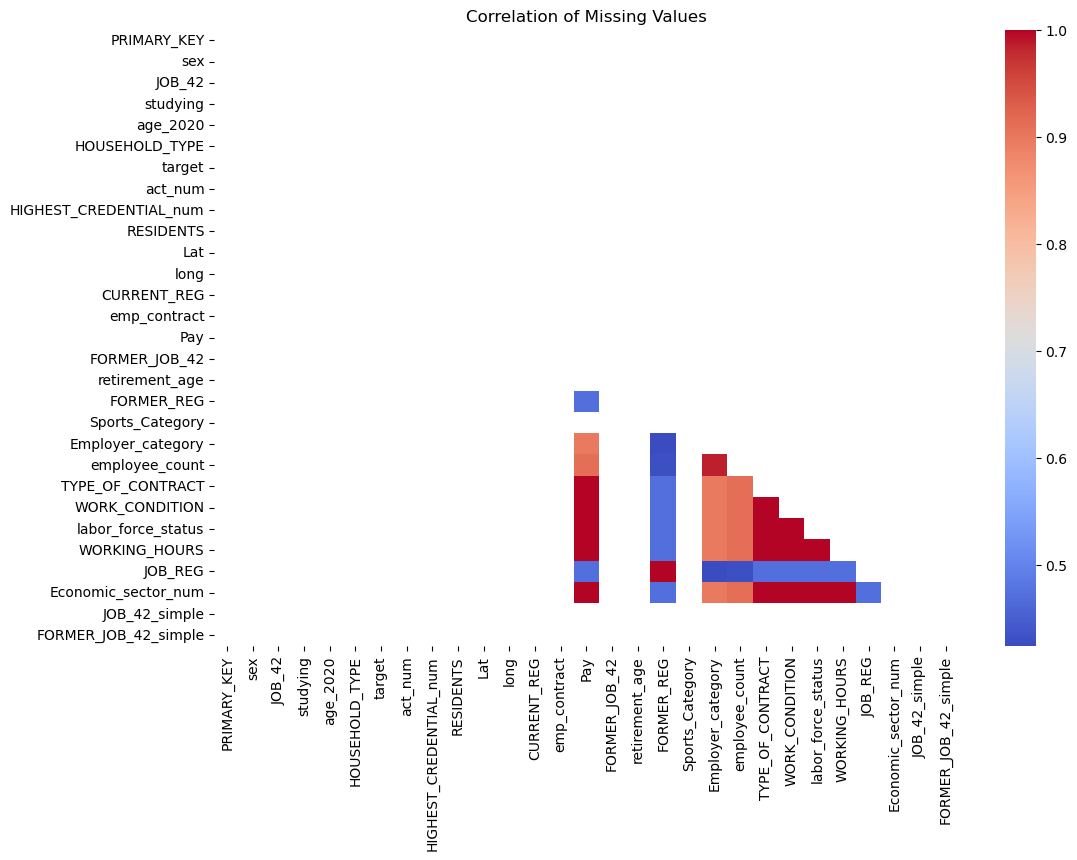

Correlation of Missing Values for Test Data


/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


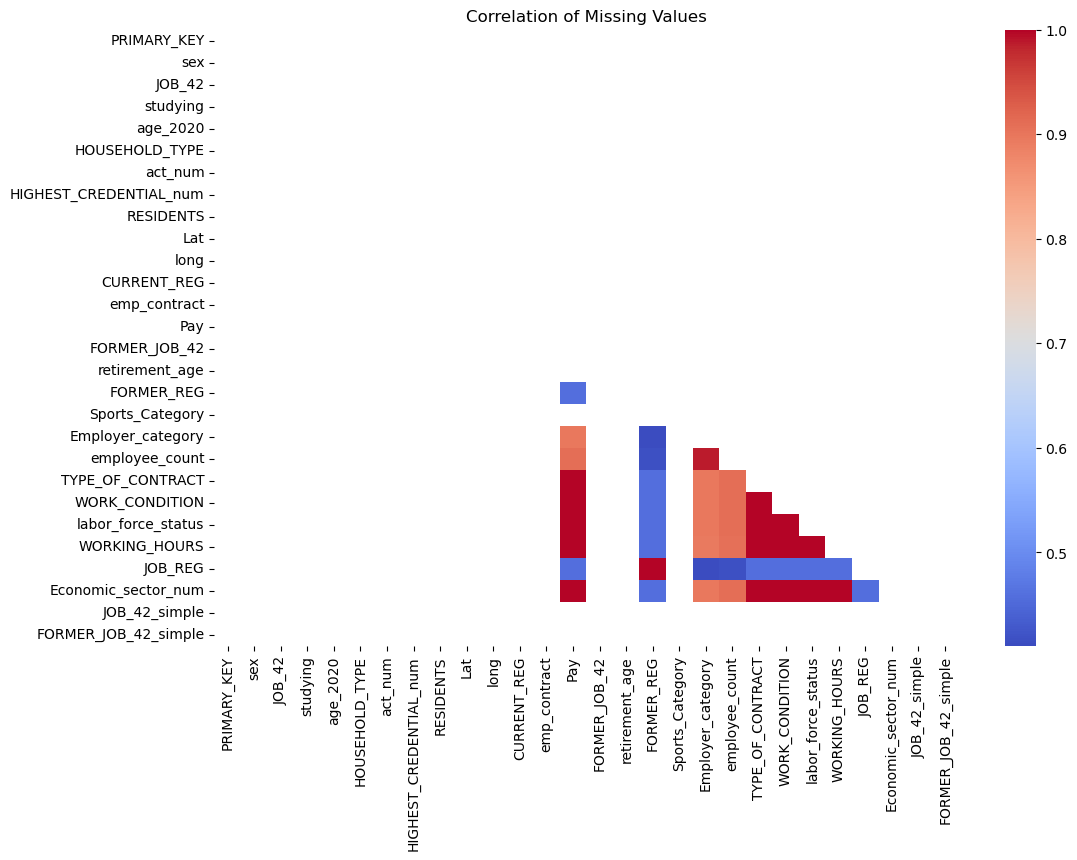

In [33]:
print("Correlation of Missing Values for Learn Data")
plot_na_correlation(learn_data)

print("Correlation of Missing Values for Test Data")
plot_na_correlation(test_data)

In [34]:
def nb_na_values_per_rows(df):
    """
    Group rows with exactly X missing values by JOB_42 categories 
    """

    # Count the number of missing values per row
    df['missing_count'] = df.isnull().sum(axis=1)

    # Filter rows with exactly 1 missing value
    filtered_df = df[df['missing_count'] == 1].copy() #adjust accordingly

    # Identify all columns with missing values for each row
    filtered_df['Missing_Variables'] = filtered_df.apply(
        lambda row: ', '.join(row.index[row.isnull()].tolist()), axis=1
    )

    # Group by JOB_42 and calculate counts of rows with 1 missing value
    job_42_counts = filtered_df.groupby('JOB_42').size().reset_index(name='Count')

    # Calculate total individuals per JOB_42
    total_counts = df['JOB_42'].value_counts().reset_index()
    total_counts.columns = ['JOB_42', 'Total']

    # Merge with filtered counts to calculate percentages
    job_42_summary = pd.merge(job_42_counts, total_counts, on='JOB_42')
    job_42_summary['Percentage'] = ((job_42_summary['Count'] / job_42_summary['Total']) * 100).round(1)

    # Add a list of all missing variables per JOB_42 category
    missing_variable_summary = (
        filtered_df.groupby('JOB_42')['Missing_Variables']
        .apply(lambda x: ', '.join(x.unique()))
        .reset_index()
    )
    missing_variable_summary.columns = ['JOB_42', 'Missing Value Column']

    # Merge the summary with the missing variable details
    result = pd.merge(job_42_summary, missing_variable_summary, on='JOB_42')

    # Drop the temporary column
    df.drop(columns=['missing_count'], inplace=True)

    return result.sort_values(by='Percentage', ascending=False)

In [35]:
nb_values = nb_na_values_per_rows(learn_data)
print(nb_values)

latex_missing_table = nb_values.to_latex(index=False, float_format="%.2f")

with open("./one_col_missing_values_table.tex", "w") as file:
    file.write(latex_missing_table)

     JOB_42  Count  Total  Percentage              Missing Value Column
15  csp_6_8     38    801         4.7                 Employer_category
6   csp_5_3     13    570         2.3  WORKING_HOURS, Employer_category
19  csp_7_8     63   3375         1.9                 Employer_category
14  csp_6_7     19   1319         1.4                 Employer_category
13  csp_6_5      4    422         0.9                 Employer_category
12  csp_6_4      5    706         0.7                 Employer_category
18  csp_7_7     21   4288         0.5  Employer_category, WORKING_HOURS
9   csp_5_6      7   1935         0.4                 Employer_category
0   csp_3_3      2    481         0.4                     WORKING_HOURS
10  csp_6_2      4    929         0.4                 Employer_category
8   csp_5_5      3   1256         0.2                 Employer_category
11  csp_6_3      3   1376         0.2                 Employer_category
7   csp_5_4      4   1642         0.2                 Employer_c

In [36]:
def na_values_by_group_for_column(df, group_col, target_col):
    # Group by `group_col` and calculate missing values for `target_col`
    grouped = df.groupby(group_col).apply(lambda group: group[target_col].isnull().sum())
    total_rows = df.groupby(group_col).size()  # Total rows per group
    missing_percent = (grouped / total_rows) * 100  # Calculate % of missing values

    # Combine counts and percentages into one DataFrame
    missing_table = pd.DataFrame({
        'Missing Values': grouped,
        '% of Total Values': missing_percent
    }).round(1)
    
    return missing_table

In [37]:
missing_job_reg_by_household = na_values_by_group_for_column(learn_data, "JOB_42", "Employer_category")
missing_job_reg_by_household

,Missing Values,% of Total Values
JOB_42,,
csp_1_1,264,100.0
csp_1_2,31,100.0
csp_1_3,90,100.0
csp_2_1,741,94.6
csp_2_2,643,92.7
csp_2_3,181,100.0
csp_3_1,489,91.2
csp_3_3,190,39.5
csp_3_4,157,21.4


# Sorting for numeric

In [39]:
columns_to_factorize = [  
    'JOB_42', 'JOB_REG', 'Economic_sector_num', 'employee_count',
    'retirement_age', 'FORMER_REG', 'TYPE_OF_CONTRACT', 'FORMER_JOB_42', 'FORMER_JOB_42_simple',
    'WORK_CONDITION', 'labor_force_status', 'emp_contract', 'Employer_category'
]  

# Function to sort and factorize columns while keeping missing values as NaN
def sort_and_factorize_with_na(data, columns):
    for column in columns:
        # Sort by the column while keeping NaN values intact
        data = data.sort_values(by=column, ascending=True, na_position='first')
        
        # Get factorized codes, skipping NaN values
        codes, uniques = pd.factorize(data[column], use_na_sentinel=True)
        
        # Assign codes to the column, replacing -1 (representing NaN) back with NaN
        data[column] = pd.Series(codes, index=data.index).replace(-1, pd.NA)
        data[column] = pd.to_numeric(data[column], errors='coerce').astype('category')
        
    return data.sort_values(by='PRIMARY_KEY', ascending=True)

# Apply the function to learn_data and test_data
learn_data = sort_and_factorize_with_na(learn_data, columns_to_factorize)
test_data = sort_and_factorize_with_na(test_data, columns_to_factorize)  

# Handling NA 

In [41]:
# Define job-specific pay and working hours
job_defaults = {
    'csp_1': {'Pay': 50000, 'WORKING_HOURS': 2860},  # Agriculture
    'csp_2_1': {'Pay': 24000, 'WORKING_HOURS': 2288},  # Artisans
    'csp_2_2': {'Pay': 39937, 'WORKING_HOURS': 2444},  # Commerçant
    'csp_2_3': {'Pay': 58248, 'WORKING_HOURS': 2704},  # Chefs d'enterprise
}

# Function to fill missing values for Pay and WORKING_HOURS
def fill_job_defaults(data, job_defaults):
    for job, defaults in job_defaults.items():
        if job == 'csp_1':
            # Special case: Handle 'startswith' condition for 'csp_1'
            job_condition = data['JOB_42'].astype(str).str.startswith(job)
        else:
            # Exact match for other job keys
            job_condition = data['JOB_42'] == job
        
        # Fill missing Pay and WORKING_HOURS
        data.loc[job_condition & data['Pay'].isna(), 'Pay'] = defaults['Pay']
        data.loc[job_condition & data['WORKING_HOURS'].isna(), 'WORKING_HOURS'] = defaults['WORKING_HOURS']

# Apply the function to the datasets
fill_job_defaults(learn_data, job_defaults)
fill_job_defaults(test_data, job_defaults)

# Pipeline

In [43]:
class ImputeMissingValues(BaseEstimator, TransformerMixin):
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        self.knn_imputer = None
        self.median_values_by_job = None

    def fit(self, X, y=None):
        X_copy = X.copy()
        X_copy['missing_count'] = X_copy.isnull().sum(axis=1)

        # Fit the KNN imputer for 'Employer_category'
        rows_with_employer_missing = X_copy[
            (X_copy['missing_count'] == 1) & (X_copy['Employer_category'].isnull())
        ]
        if not rows_with_employer_missing.empty:
            # Ensure 'Employer_category' is numeric
            numeric_data = rows_with_employer_missing[['Employer_category']].apply(pd.to_numeric, errors='coerce')
            if not numeric_data.empty:
                self.knn_imputer = KNNImputer(n_neighbors=self.n_neighbors)
                self.knn_imputer.fit(numeric_data)

        # Calculate medians for 'WORKING_HOURS' grouped by 'JOB_42'
        rows_with_working_hours_missing = X_copy[
            (X_copy['missing_count'] == 1) & (X_copy['WORKING_HOURS'].isnull())
        ]
        self.median_values_by_job = (
            rows_with_working_hours_missing.groupby('JOB_42', observed=False)['WORKING_HOURS'].median()
        )
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy['missing_count'] = X_copy.isnull().sum(axis=1)

        # Impute 'Employer_category'
        rows_with_employer_missing = X_copy[
            (X_copy['missing_count'] == 1) & (X_copy['Employer_category'].isnull())
        ]
        if not rows_with_employer_missing.empty and self.knn_imputer is not None:
            numeric_data = rows_with_employer_missing[['Employer_category']].apply(pd.to_numeric, errors='coerce')
            if not numeric_data.empty:
                imputed_values = self.knn_imputer.transform(numeric_data)
                if imputed_values.shape[1] > 0:  # Ensure we have valid data
                    X_copy.loc[rows_with_employer_missing.index, 'Employer_category'] = imputed_values[:, 0]

        # Impute 'WORKING_HOURS'
        rows_with_working_hours_missing = X_copy[
            (X_copy['missing_count'] == 1) & (X_copy['WORKING_HOURS'].isnull())
        ]
        for idx in rows_with_working_hours_missing.index:
            job_42_category = X_copy.loc[idx, 'JOB_42']
            if job_42_category in self.median_values_by_job:
                X_copy.loc[idx, 'WORKING_HOURS'] = self.median_values_by_job[job_42_category]

        # Drop the temporary column
        X_copy.drop(columns=['missing_count'], inplace=True)

        return X_copy


In [44]:
class ImputeRowsWith2Missing(BaseEstimator, TransformerMixin):
    def __init__(self, n_neighbors=5):
        self.knn_imputer = KNNImputer(n_neighbors=n_neighbors)

    def fit(self, X, y=None):
        X_copy = X.copy()
        X_copy['missing_count'] = X_copy.isnull().sum(axis=1)
        self.rows_with_2_missing = X_copy[X_copy['missing_count'] == 2].drop(columns='missing_count')
        if not self.rows_with_2_missing.empty:
            self.knn_imputer.fit(self.rows_with_2_missing)
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy['missing_count'] = X_copy.isnull().sum(axis=1)
        rows_with_2_missing = X_copy[X_copy['missing_count'] == 2].drop(columns='missing_count')

        if not rows_with_2_missing.empty:
            imputed_array = self.knn_imputer.transform(rows_with_2_missing)
            imputed_df = pd.DataFrame(imputed_array, columns=rows_with_2_missing.columns, index=rows_with_2_missing.index)

            for col in imputed_df.columns:
                if isinstance(X[col].dtype, pd.CategoricalDtype):
                    imputed_df[col] = pd.Categorical.from_codes(
                        imputed_df[col].round().astype(int),
                        categories=X[col].cat.categories
                    )
                else:
                    imputed_df[col] = imputed_df[col]

            X_copy.loc[rows_with_2_missing.index, :] = imputed_df

        X_copy.drop(columns=['missing_count'], inplace=True)
        return X_copy


In [45]:
class MICEImputationForCategorical(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_impute, max_iter=10, random_state=42):
        self.columns_to_impute = columns_to_impute
        self.mice_imputer = IterativeImputer(max_iter=max_iter, random_state=random_state)

    def fit(self, X, y=None):
        self.mice_imputer.fit(X[self.columns_to_impute])
        return self

    def transform(self, X):
        X_copy = X.copy()
        imputed_data = self.mice_imputer.transform(X_copy[self.columns_to_impute])
        imputed_data_df = pd.DataFrame(imputed_data, columns=self.columns_to_impute, index=X_copy.index)
        X_copy[self.columns_to_impute] = imputed_data_df.round(0)
        return X_copy


In [46]:
columns_to_impute = [
    'Employer_category', 'employee_count', 'WORKING_HOURS', 
    'Pay', 'TYPE_OF_CONTRACT', 'WORK_CONDITION', 
    'labor_force_status', 'Economic_sector_num', 
    'FORMER_REG', 'JOB_REG'
]
pipeline = Pipeline([
    ('impute_missing_values', ImputeMissingValues(n_neighbors=5)),
    ('impute_rows_with_2_missing', ImputeRowsWith2Missing(n_neighbors=5)),
    ('mice_imputation', MICEImputationForCategorical(columns_to_impute=columns_to_impute, max_iter=10, random_state=42))
])

# Prediction

## LINEAR MODEL

In [49]:
learn_lin = pipeline.fit_transform(learn_data)

In [50]:
#One-hot-encoding
def preprocess_learn_data(data):
    # Drop unwanted columns
    columns_to_drop = ['JOB_42', 'FORMER_JOB_42', 'RESIDENTS']
    data = data.drop(columns=columns_to_drop, errors='ignore')
    
    # Columns to one-hot encode
    columns_to_encode = [
        'sex', 'JOB_42_simple', 'HOUSEHOLD_TYPE', 'act_num', 'emp_contract', 
        'Sports_Category', 'JOB_REG', 'FORMER_REG', 'CURRENT_REG', 'Employer_category',
        'Economic_sector_num', 'TYPE_OF_CONTRACT', 'WORK_CONDITION',
        'labor_force_status', 'FORMER_JOB_42_simple'
    ]
    
    # Convert columns to categorical type if not already
    for col in columns_to_encode:
        if col in data.columns:
            data[col] = data[col].astype('category')
    
    # Apply one-hot encoding
    data = pd.get_dummies(data, columns=columns_to_encode, drop_first=True)
    
    return data

# Example usage:
learn_lin = preprocess_learn_data(learn_lin)


In [51]:
x_train_lin = learn_lin.drop(columns=["target"])
y_train_lin = learn_lin["target"]

X_train_lin, X_test_lin, Y_train_lin, Y_test_lin = train_test_split(x_train_lin,
                                                    y_train_lin, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [52]:
# Example GridSearchCV for Linear Regression
param_grid = {'fit_intercept': [True, False]}  # Define your hyperparameter grid

# Create a Linear Regression model
lr = LinearRegression()

# Perform grid search with cross-validation
lin_res = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5)

# Fit the GridSearchCV model
lin_res.fit(X_train_lin, Y_train_lin)

# Output the best model and its score
print(f"Best model: {lin_res.best_estimator_}")
print(f"Best score: {lin_res.best_score_}")


Best model: LinearRegression(fit_intercept=False)
Best score: 0.6075587696250965


In [53]:
train_predictions = lin_res.predict(X_train_lin)
print("R² for training set: ", r2_score(Y_train_lin, train_predictions))
print("RMSE on the learning set:", root_mean_squared_error(Y_train_lin, lin_res.predict(X_train_lin)))

R² for training set:  0.6114298883809203
RMSE on the learning set: 1.281517735512234


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


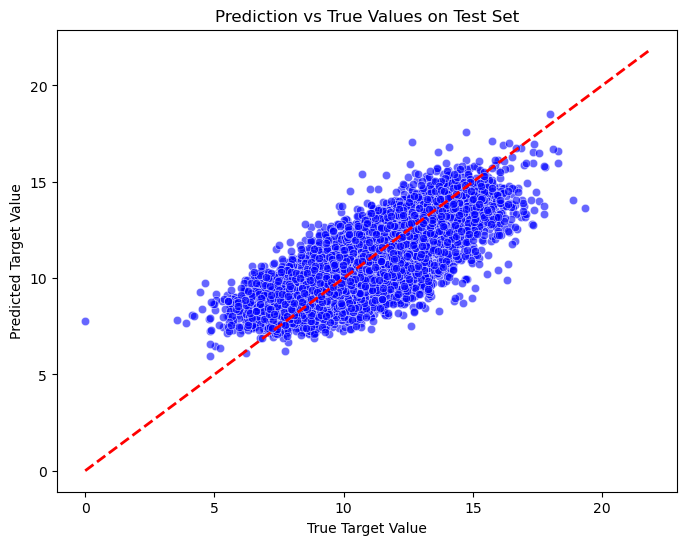

In [54]:
train_predictions = lin_res.predict(X_train_lin)
test_predictions = lin_res.predict(X_test_lin)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=Y_test_lin, y=test_predictions, alpha=0.6, color="blue")
plt.plot([y_train_lin.min(), y_train_lin.max()], [y_train_lin.min(), y_train_lin.max()], "--r", linewidth=2)  # Ideal predictions
plt.xlabel('True Target Value')
plt.ylabel('Predicted Target Value')
plt.title('Prediction vs True Values on Test Set')
plt.savefig("./Prediction_vs_True_linear.png", format='png', dpi=300)  
plt.show()

In [55]:
error_metrics_lin = pd.DataFrame({
    'Metric': ['R²', 'RMSE'],
    'Train': [r2_score(Y_train_lin, train_predictions), root_mean_squared_error(Y_train_lin, lin_res.predict(X_train_lin))],
    'Test': [r2_score(Y_test_lin, test_predictions), root_mean_squared_error(Y_test_lin, lin_res.predict(X_test_lin))]
})

# Set 'Metric' as the index to have a clean format
error_metrics_lin.set_index('Metric', inplace=True)

# Convert to LaTeX format
error_metrics_lin_table = error_metrics_lin.to_latex(index=True, float_format="%.2f")

with open("./error_metrics_lin.tex", "w") as file:
    file.write(error_metrics_lin_table)

## RANDOM FOREST

In [57]:
learn_rf = learn_data

In [58]:
x_train_rf = learn_rf.drop(columns=["target"])
y_train_rf = learn_rf["target"]

x_train_rf = pipeline.fit_transform(x_train_rf)
x_train_rf = x_train_rf.drop(['JOB_42_simple', 'FORMER_JOB_42_simple', 'RESIDENTS'], axis=1)

X_train_rf, X_test_rf, Y_train_rf, Y_test_rf = train_test_split(x_train_rf,
                                                    y_train_rf, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [59]:
param_grid_rf = {     # Number of trees in the forest
    'max_depth': [5, 10, 30, 50],    
    'min_samples_split': [5, 10, 20]  
}

# Define cross-validation with 5 folds
cv_folds = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the RandomForestRegressor model
rf = RandomForestRegressor(random_state=42)  #need to add that in the pipeline 

# Set up the GridSearchCV for RandomForestRegressor with appropriate scoring metric
rf_search = GridSearchCV(rf, param_grid_rf, cv=cv_folds, n_jobs=-1, scoring="neg_mean_squared_error")

In [60]:
# Fit the model on the training data
rf_res = rf_search.fit(X_train_rf, Y_train_rf)

In [61]:
# Get the best model after GridSearchCV
best_model_rf = rf_res.best_estimator_

# Output the best model and its score
print(f"Best model: {best_model_rf}")
print(f"Best score: {rf_res.best_score_}")

Best model: RandomForestRegressor(max_depth=50, min_samples_split=5, random_state=42)
Best score: -1.029288058463235


In [62]:
cv_scores = cross_val_score(best_model_rf, X_train_rf, Y_train_rf, cv=5, scoring='r2')
print(f"Cross-validated R2 scores: {cv_scores}")
print(f"Average R2: {np.mean(cv_scores):.2f}")

Cross-validated R2 scores: [0.75483286 0.75062799 0.75605827 0.76695367 0.75296413]
Average R2: 0.76


In [63]:
train_predictions = best_model_rf.predict(X_train_rf)
test_predictions = best_model_rf.predict(X_test_rf)

print("R² for training set: ", r2_score(Y_train_rf, train_predictions))
print("R² for test set: ", r2_score(Y_test_rf, test_predictions))
print("RMSE on the learning set:", root_mean_squared_error(Y_train_rf, best_model_rf.predict(X_train_rf)))
print("RMSE on the test set:", root_mean_squared_error(Y_test_rf, best_model_rf.predict(X_test_rf)))

R² for training set:  0.9541767879547829
R² for test set:  0.771341611697508
RMSE on the learning set: 0.4400810712700401
RMSE on the test set: 0.9887835478619862


In [64]:
error_metrics = pd.DataFrame({
    'Metric': ['R²', 'RMSE'],
    'Train': [r2_score(Y_train_rf, train_predictions), root_mean_squared_error(Y_train_rf, best_model_rf.predict(X_train_rf))],
    'Test': [r2_score(Y_test_rf, test_predictions), root_mean_squared_error(Y_test_rf, best_model_rf.predict(X_test_rf))]
})

# Set 'Metric' as the index to have a clean format
error_metrics.set_index('Metric', inplace=True)

# Convert to LaTeX format
error_metrics_table = error_metrics.to_latex(index=True, float_format="%.2f")

with open("./error_metrics.tex", "w") as file:
    file.write(error_metrics_table)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


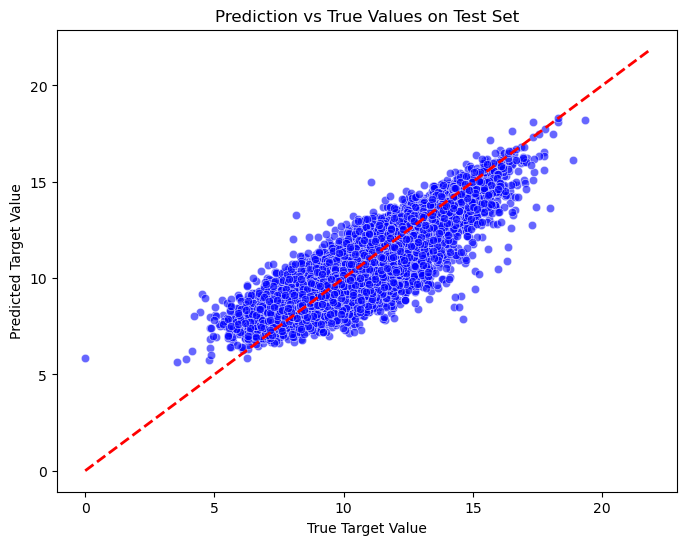

In [65]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=Y_test_rf, y=test_predictions, alpha=0.6, color="blue")
plt.plot([y_train_rf.min(), y_train_rf.max()], [y_train_rf.min(), y_train_rf.max()], "--r", linewidth=2)  # Ideal predictions
plt.xlabel('True Target Value')
plt.ylabel('Predicted Target Value')
plt.title('Prediction vs True Values on Test Set')
plt.savefig("./Prediction_vs_True_rf.png", format='png', dpi=300)  
plt.show()

## EXTRA ANALYISIS

In [67]:
# Calculate correlation
cor = learn_data.drop(['JOB_42_simple', 'FORMER_JOB_42_simple', 'RESIDENTS'], axis=1)

correlation_matrix = cor.corr()

# Find correlations with the target variable
target_corr = correlation_matrix['target'].sort_values(ascending=False)

print(target_corr)

target_corr_table = target_corr.to_latex(float_format="%.2f")

with open("./target_corr.tex", "w") as file:
    file.write(target_corr_table)

target                    1.000000
studying                  0.474091
WORK_CONDITION            0.292330
labor_force_status        0.265290
Economic_sector_num       0.251115
FORMER_REG                0.224399
retirement_age            0.220271
TYPE_OF_CONTRACT          0.209469
FORMER_JOB_42             0.196521
employee_count            0.182398
emp_contract              0.157168
act_num                   0.122411
JOB_42                    0.096326
Employer_category         0.071786
Lat                       0.049312
Sports_Category           0.031436
JOB_REG                   0.020863
HOUSEHOLD_TYPE           -0.016022
CURRENT_REG              -0.018718
PRIMARY_KEY              -0.032823
long                     -0.098229
HIGHEST_CREDENTIAL_num   -0.175120
sex                      -0.180036
Pay                      -0.283767
WORKING_HOURS            -0.284932
age_2020                 -0.315319
Name: target, dtype: float64


In [149]:
# Get feature importances
feature_importances = pd.DataFrame({
    'Feature': x_train_rf.columns,
    'Importance': best_model_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances)

feature_importances_table = feature_importances.to_latex(index=False, float_format="%.2f")

with open("./feature_importances.tex", "w") as file:
    file.write(feature_importances_table)

                   Feature  Importance
3                 studying    0.228534
7   HIGHEST_CREDENTIAL_num    0.090028
5           HOUSEHOLD_TYPE    0.089984
2                   JOB_42    0.079188
11            emp_contract    0.077794
1                      sex    0.072802
6                  act_num    0.058134
0              PRIMARY_KEY    0.052487
9                     long    0.051714
4                 age_2020    0.046551
8                      Lat    0.037995
12                     Pay    0.023404
22           WORKING_HOURS    0.017782
14          retirement_age    0.013225
13           FORMER_JOB_42    0.010556
16         Sports_Category    0.008271
18          employee_count    0.007284
24     Economic_sector_num    0.007183
15              FORMER_REG    0.005450
23                 JOB_REG    0.005329
10             CURRENT_REG    0.004868
17       Employer_category    0.004654
20          WORK_CONDITION    0.002374
19        TYPE_OF_CONTRACT    0.002257
21      labor_force_statu

# Prediction on Test Dataset

In [70]:
test_rf = pipeline.transform(test_data)
test_rf = test_rf.drop(['JOB_42_simple', 'FORMER_JOB_42_simple', 'RESIDENTS'], axis=1)

test_predictions = best_model_rf.predict(test_rf)  # Replace with your model's prediction method

predictions_df = pd.DataFrame({
    'PRIMARY_KEY': test_rf['PRIMARY_KEY'], 
    'target': test_predictions
})

# Save the predictions to a CSV file
predictions_df.to_csv('predictions.csv', index=False, sep=',', float_format='%.6f')  # Save with US decimal notation

In [71]:
predictions_df

,PRIMARY_KEY,target
0,2,9.010197
1,3,11.494940
2,4,9.044146
3,6,12.073183
4,9,8.818052
...,...,...
50035,100071,8.139548
50036,100074,8.625745
50037,100075,8.784651
50038,100080,11.828394
